In [69]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import csv
import pandas as pd
import numpy as np

In [6]:
def get_dataset(name):
    df = pd.read_csv(name, sep=';', index_col=0, encoding="Latin1")
    df = df[::-1]

    df.columns = ['Siste', 'Kjoper', 'Selger', 'Hoy', 'Lav', 'Totalt_omsatt_NOK', 'Totalt_antall_aksjer_omsatt', 'Antall_off_handler', 'Antall_handler_totalt', 'VWAP']
    return df


def get_currency_data(name):
    df = pd.read_csv(name, sep=';', index_col=0)
    return df

MHG = get_dataset("data\\MHG_data.csv")
#nok = get_currency_data("")

In [7]:
def plot_dataframe(df):
    df.plot()
    plt.show()
    

def plot_siste(df):
    df = df.Siste
    df.plot()
    plt.show()

    
def plot_kjoper(df):
    df = df.Kjoper
    df.plot()
    plt.show()
    
    
def plot_omsatt_nok(df):
    df = df.Totalt_omsatt_NOK
    df.plot()
    plt.show()
    
    
def plot_omsatt_antall_aksjer(df):
    df = df.Totalt_antall_aksjer_omsatt
    df.plot()
    plt.show()

def plot_antall_handler_off(df):
    df = df.Antall_off_handler
    df.plot()
    plt.show()
    
    
def plot_antall_handler_totalt(df):
    df = df.Antall_handler_totalt
    df.plot()
    plt.show()


def plot_VWAP(df):
    df = df.VWAP
    df.plot()
    plt.show()

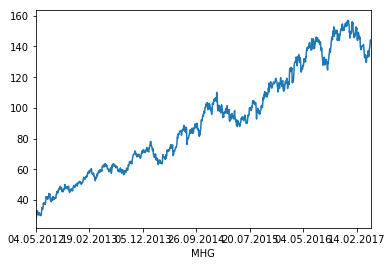

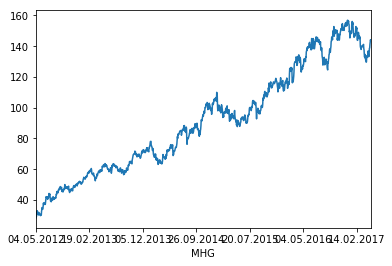

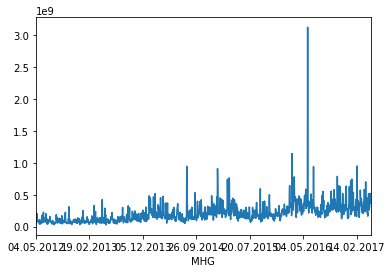

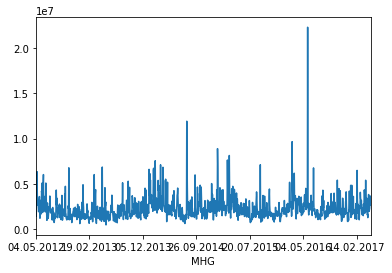

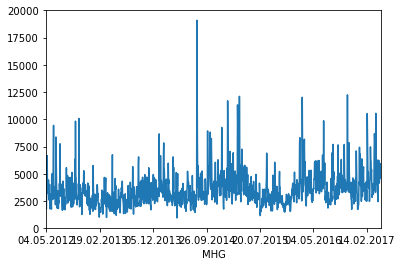

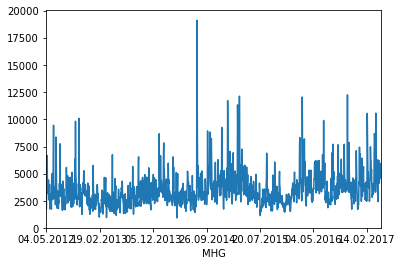

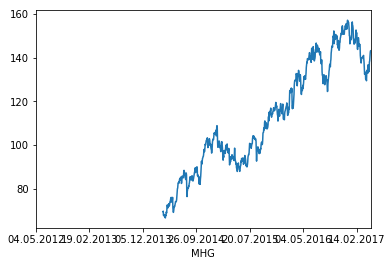

In [8]:
plot_siste(MHG)
plot_kjoper(MHG)
plot_omsatt_nok(MHG)
plot_omsatt_antall_aksjer(MHG)
plot_antall_handler_off(MHG)
plot_antall_handler_totalt(MHG)
plot_VWAP(MHG)